In [1]:
import numpy as np
import pandas as pd

def Peaks(x, y):
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return z

def GetGrid(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = Peaks(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_582412/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


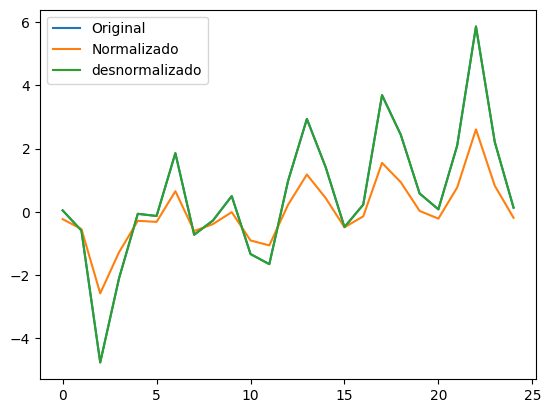

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 16.50 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-25 02:14:33.825537: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:14:33.857574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 02:14:33.857621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 02:14:33.858867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 02:14:33.865271: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:14:33.865958: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-08-25 02:14:34.935695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_8,0.945201,0.780282,0.742748,0.838007,0.237267,1.469258,0.920175,0.373632,0.913746,0.487101,4.507152,0.494772,132.877138,274.212311
model_1_1_7,0.944441,0.779458,0.743480,0.838149,0.240556,1.474769,0.917558,0.373305,0.914308,0.490465,4.555763,0.498189,132.849607,274.184780
model_1_1_6,0.943307,0.778794,0.742808,0.835012,0.245464,1.479207,0.919961,0.380541,0.920709,0.495444,4.628321,0.503246,132.809206,274.144379
model_1_1_5,0.942184,0.778639,0.741742,0.831269,0.250327,1.480240,0.923774,0.389173,0.931709,0.500327,4.700195,0.508206,132.769975,274.105148
model_1_1_4,0.929379,0.773815,0.735715,0.793635,0.305770,1.512499,0.945331,0.475974,1.004678,0.552965,5.519730,0.561674,132.369842,273.705015
model_1_1_3,0.928442,0.772993,0.736233,0.792569,0.309830,1.517995,0.943481,0.478433,1.008897,0.556624,5.579743,0.565390,132.343461,273.678634
model_1_1_2,0.927827,0.771196,0.738139,0.795334,0.312492,1.530014,0.936662,0.472056,1.001727,0.559010,5.619083,0.567813,132.326354,273.661527
model_1_1_1,0.926739,0.769927,0.738157,0.794045,0.317203,1.538499,0.936597,0.475029,0.999707,0.563208,5.688719,0.572078,132.296428,273.631600
model_1_1_0,0.908216,0.749515,0.739884,0.780534,0.397403,1.674993,0.930421,0.506193,1.019352,0.630399,6.874190,0.640327,131.845610,273.180783


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.983698,0.809456,0.765948,0.982722,0.070583,1.274168,0.837189,0.047882,0.516672,0.265675,2.043321,0.269859,135.301929,276.637102
model_1_2_8,0.981006,0.808408,0.760114,0.979771,0.082239,1.281178,0.858058,0.056059,0.567063,0.286773,2.215607,0.291289,134.996259,276.331432
model_1_2_7,0.978271,0.807160,0.756193,0.976494,0.094083,1.289523,0.872083,0.065141,0.604540,0.306730,2.390683,0.311560,134.727156,276.062329
model_1_2_6,0.975069,0.805517,0.751393,0.972890,0.107944,1.300506,0.889253,0.075131,0.648220,0.328548,2.595569,0.333723,134.452286,275.787459
model_1_2_5,0.974744,0.804463,0.750979,0.972642,0.109350,1.307557,0.890732,0.075818,0.671500,0.330681,2.616354,0.335889,134.426401,275.761574
model_1_2_4,0.971034,0.802584,0.745481,0.968460,0.125416,1.320120,0.910398,0.087407,0.720430,0.354141,2.853831,0.359719,134.152238,275.487410
model_1_2_3,0.967163,0.799768,0.739982,0.964626,0.142176,1.338955,0.930069,0.098033,0.778785,0.377063,3.101573,0.383001,133.901375,275.236547
model_1_2_2,0.962345,0.797265,0.733765,0.959068,0.163038,1.355692,0.952308,0.113436,0.832392,0.403779,3.409935,0.410138,133.627547,274.962720
model_1_2_1,0.956878,0.794350,0.727295,0.952540,0.186709,1.375184,0.975449,0.131525,0.889072,0.432098,3.759828,0.438903,133.356410,274.691583
model_1_2_0,0.949917,0.790609,0.720346,0.944070,0.216847,1.400202,1.000308,0.154999,0.953928,0.465668,4.205311,0.473002,133.057129,274.392301


DataFrame salvo em ../results/metrics_1_2


+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.995674,0.812112,0.792139,0.994062,0.018729,1.256407,0.743508,0.022625,0.193298,0.136855,1.276847,0.139010,137.955329,279.290501
model_1_3_8,0.995102,0.811532,0.791323,0.993552,0.021206,1.260287,0.746426,0.024565,0.204215,0.145622,1.313453,0.147916,137.706959,279.042132
model_1_3_7,0.994476,0.810975,0.790010,0.993099,0.023919,1.264010,0.751121,0.026293,0.216261,0.154656,1.353552,0.157092,137.466198,278.801371
model_1_3_6,0.994380,0.810904,0.789896,0.993040,0.024333,1.264484,0.751531,0.026515,0.218011,0.155990,1.359676,0.158447,137.431848,278.767021
model_1_3_0,0.985862,0.810505,0.769357,0.989346,0.061215,1.267157,0.824996,0.040591,0.478032,0.247416,1.904840,0.251312,135.586741,276.921914
model_1_3_5,0.992565,0.809552,0.791987,0.989882,0.032191,1.273525,0.744052,0.038548,0.258540,0.179419,1.475831,0.182244,136.872133,278.207305
model_1_3_3,0.990957,0.809490,0.791089,0.990305,0.039155,1.273942,0.747262,0.036937,0.305519,0.197875,1.578761,0.200991,136.480478,277.815650
model_1_3_4,0.991850,0.809473,0.789430,0.989837,0.035287,1.274053,0.753197,0.038718,0.281466,0.187849,1.521594,0.190807,136.688477,278.023649
model_1_3_2,0.989753,0.808543,0.790268,0.989601,0.044367,1.280276,0.750201,0.039619,0.325488,0.210636,1.655815,0.213953,136.230500,277.565673
model_1_3_1,0.988438,0.807706,0.789131,0.988555,0.050061,1.285870,0.754265,0.043605,0.341539,0.223744,1.739981,0.227268,135.989008,277.324181


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.997922,0.821144,0.800845,0.992804,0.008997,1.196010,0.712365,0.022598,0.150295,0.094851,1.132984,0.096345,139.421796,280.756969
model_1_4_8,0.997856,0.820598,0.799000,0.993371,0.009285,1.199663,0.718964,0.020817,0.154585,0.096356,1.137239,0.097874,139.358806,280.693978
model_1_4_7,0.997841,0.820519,0.798771,0.993432,0.009348,1.200187,0.719784,0.020626,0.155308,0.096687,1.138184,0.098210,139.345087,280.680260
model_1_4_6,0.997741,0.819895,0.796904,0.993934,0.009780,1.204366,0.726461,0.019048,0.160696,0.098892,1.144558,0.100450,139.254895,280.590067
model_1_4_5,0.997720,0.819809,0.796681,0.993974,0.009873,1.204939,0.727260,0.018925,0.161596,0.099365,1.145945,0.100930,139.235804,280.570977
model_1_4_4,0.997553,0.819257,0.794588,0.994199,0.010596,1.208631,0.734748,0.018219,0.168295,0.102936,1.156622,0.104557,139.094586,280.429758
model_1_4_3,0.997355,0.818523,0.792590,0.994450,0.011453,1.213537,0.741894,0.017429,0.174909,0.107017,1.169287,0.108702,138.939071,280.274244
model_1_4_2,0.997087,0.817801,0.790581,0.994482,0.012613,1.218366,0.749081,0.017328,0.182105,0.112308,1.186439,0.114076,138.746053,280.081226
model_1_4_1,0.996741,0.816843,0.788794,0.994381,0.014109,1.224771,0.755473,0.017647,0.189852,0.118783,1.208558,0.120654,138.521825,279.856997
model_1_4_0,0.996350,0.815625,0.788297,0.994045,0.015804,1.232920,0.757250,0.018701,0.195340,0.125715,1.233609,0.127695,138.294963,279.630135


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_4,0.998025,0.822393,0.797961,0.996335,0.008550,1.187660,0.722683,0.016739,0.211519,0.092468,1.126388,0.093925,139.523550,280.858723
model_1_5_5,0.997953,0.822347,0.796561,0.995168,0.008865,1.187968,0.727690,0.022070,0.226570,0.094152,1.131032,0.095635,139.451374,280.786547
model_1_5_6,0.997840,0.822334,0.795380,0.993935,0.009353,1.188053,0.731915,0.027700,0.240439,0.096712,1.138254,0.098235,139.344073,280.679245
model_1_5_7,0.997711,0.822201,0.794358,0.992740,0.009911,1.188942,0.735571,0.033158,0.252018,0.099552,1.146493,0.101120,139.228306,280.563479
model_1_5_8,0.997614,0.822160,0.793615,0.991810,0.010329,1.189214,0.738229,0.037403,0.260455,0.101632,1.152677,0.103232,139.145604,280.480777
model_1_5_3,0.998155,0.822083,0.799721,0.997553,0.007987,1.189730,0.716386,0.011174,0.192008,0.089371,1.118062,0.090779,139.659836,280.995009
model_1_5_2,0.998117,0.821960,0.800474,0.998341,0.008152,1.190556,0.713693,0.007577,0.174873,0.090286,1.120493,0.091708,139.619080,280.954252
model_1_5_9,0.997383,0.821750,0.791532,0.990309,0.011331,1.191960,0.745679,0.044258,0.274925,0.106448,1.167493,0.108125,138.960377,280.295549
model_1_5_0,0.997993,0.821672,0.802067,0.999011,0.008691,1.192477,0.707995,0.004518,0.149959,0.093226,1.128467,0.094694,139.490915,280.826088
model_1_5_1,0.998015,0.821665,0.801733,0.998956,0.008595,1.192525,0.709190,0.004769,0.154379,0.092710,1.127048,0.094170,139.513120,280.848293


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  22
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.999088,0.821162,0.799672,0.999193,0.003948,1.195890,0.716562,0.004132,0.161013,0.062836,1.058362,0.063825,141.068926,282.404099
model_1_6_8,0.998986,0.820418,0.801297,0.999186,0.004390,1.200865,0.710748,0.004170,0.165846,0.066257,1.064890,0.067300,140.856875,282.192048
model_1_6_6,0.998932,0.819619,0.801997,0.999108,0.004625,1.206208,0.708246,0.004568,0.163083,0.068009,1.068367,0.069080,140.752468,282.087640
model_1_6_7,0.998985,0.819576,0.801053,0.999226,0.004395,1.206499,0.711622,0.003965,0.163575,0.066296,1.064966,0.067340,140.854529,282.189701
model_1_6_3,0.998790,0.818798,0.802344,0.999122,0.005239,1.211697,0.707003,0.004499,0.171871,0.072380,1.077437,0.073519,140.503324,281.838497
model_1_6_4,0.998810,0.818777,0.802055,0.999134,0.005151,1.211840,0.708038,0.004436,0.171131,0.071770,1.076137,0.072900,140.537179,281.872351
model_1_6_5,0.998817,0.818619,0.802552,0.999111,0.005122,1.212893,0.706259,0.004554,0.168580,0.071572,1.075718,0.072699,140.548228,281.883401
model_1_6_1,0.998226,0.818488,0.801887,0.999272,0.007683,1.213770,0.708640,0.003730,0.214769,0.087651,1.113561,0.089031,139.737583,281.072756
model_1_6_0,0.998183,0.818384,0.801433,0.999272,0.007866,1.214466,0.710262,0.003728,0.216173,0.088691,1.116272,0.090088,139.690397,281.025569
model_1_6_2,0.998498,0.817510,0.802744,0.998995,0.006503,1.220310,0.705575,0.005149,0.187708,0.080639,1.096120,0.081909,140.071069,281.406242


DataFrame salvo em ../results/metrics_1_6


+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_1,0.999122,0.821228,0.795536,0.999334,0.003803,1.195450,0.731354,0.002454,0.162917,0.061668,1.056213,0.062639,141.143956,282.479128
model_1_7_0,0.999147,0.820563,0.800037,0.999547,0.003693,1.199893,0.715256,0.001670,0.156343,0.060767,1.054582,0.061724,141.202866,282.538038
model_1_7_2,0.999280,0.820182,0.797514,0.999337,0.003115,1.202445,0.724281,0.002443,0.139447,0.055817,1.046052,0.056696,141.542733,282.877905
model_1_7_3,0.999359,0.820085,0.796845,0.999321,0.002773,1.203092,0.726675,0.002502,0.132987,0.052662,1.040993,0.053491,141.775446,283.110619
model_1_7_4,0.999376,0.820023,0.796771,0.999329,0.002701,1.203506,0.726938,0.002473,0.131630,0.051967,1.039918,0.052786,141.828578,283.163751
model_1_7_6,0.999551,0.819140,0.795998,0.999284,0.001945,1.209414,0.729703,0.002638,0.112636,0.044099,1.028745,0.044793,142.485318,283.820490
model_1_7_7,0.999553,0.819127,0.796042,0.999266,0.001937,1.209496,0.729546,0.002704,0.110657,0.044015,1.028637,0.044708,142.492877,283.828050
model_1_7_5,0.999513,0.818993,0.797877,0.999384,0.002108,1.210396,0.722983,0.002271,0.115905,0.045916,1.031163,0.046639,142.323808,283.658980
model_1_7_8,0.999600,0.818388,0.795957,0.999235,0.001732,1.214443,0.729848,0.002820,0.103505,0.041622,1.025607,0.042277,142.716551,284.051724
model_1_7_9,0.999605,0.817554,0.795959,0.999117,0.001712,1.220017,0.729842,0.003254,0.093983,0.041372,1.025301,0.042024,142.740598,284.075771


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  25
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.998705,0.823621,0.802984,0.995771,0.005608,1.179444,0.704714,0.026630,0.197052,0.074887,1.082896,0.076066,140.367095,281.702268
model_1_8_5,0.998830,0.823139,0.800453,0.996344,0.005068,1.182668,0.713767,0.023024,0.192699,0.071187,1.074906,0.072308,140.569798,281.904970
model_1_8_7,0.998753,0.822922,0.802664,0.995970,0.005399,1.184121,0.705859,0.025380,0.189661,0.073475,1.079798,0.074632,140.443262,281.778435
model_1_8_8,0.998750,0.822898,0.802817,0.995955,0.005413,1.184280,0.705313,0.025473,0.188874,0.073574,1.080014,0.074733,140.437846,281.773018
model_1_8_4,0.998921,0.822839,0.800499,0.996670,0.004672,1.184677,0.713602,0.020972,0.186594,0.068354,1.069063,0.069430,140.732231,282.067403
model_1_8_6,0.998784,0.822418,0.802118,0.996121,0.005265,1.187495,0.707813,0.024428,0.187516,0.072560,1.077824,0.073703,140.493346,281.828518
model_1_8_3,0.999069,0.821860,0.801628,0.997189,0.004029,1.191222,0.709566,0.017702,0.172711,0.063474,1.059553,0.064473,141.028530,282.363703
model_1_8_2,0.999173,0.821419,0.801473,0.997583,0.003583,1.194170,0.710118,0.015219,0.164641,0.059854,1.052955,0.060797,141.263384,282.598556
model_1_8_1,0.999294,0.820893,0.801170,0.998051,0.003055,1.197690,0.711205,0.012273,0.153816,0.055275,1.045162,0.056145,141.581744,282.916917
model_1_8_0,0.999411,0.820263,0.800879,0.998523,0.002552,1.201903,0.712246,0.009299,0.140902,0.050521,1.037728,0.051317,141.941458,283.276630


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.998808,0.825190,0.802147,0.999180,0.005162,1.168954,0.707709,0.002535,0.187252,0.071846,1.076299,0.072977,140.532939,281.868112
model_1_9_7,0.998778,0.825131,0.801808,0.999240,0.005292,1.169352,0.708922,0.002350,0.191211,0.072747,1.078226,0.073893,140.483057,281.818229
model_1_9_8,0.998802,0.825073,0.802128,0.999230,0.005187,1.169738,0.707776,0.002380,0.187611,0.072024,1.076679,0.073159,140.523012,281.858184
model_1_9_6,0.998773,0.824996,0.801819,0.999294,0.005315,1.170255,0.708880,0.002184,0.191593,0.072901,1.078556,0.074049,140.474631,281.809804
model_1_9_5,0.998793,0.824534,0.802556,0.999633,0.005225,1.173339,0.706247,0.001133,0.191116,0.072283,1.077231,0.073422,140.508652,281.843825
model_1_9_4,0.998780,0.824371,0.802497,0.999678,0.005282,1.174435,0.706455,0.000995,0.192140,0.072679,1.078079,0.073824,140.486817,281.821990
model_1_9_2,0.998752,0.824223,0.802522,0.999731,0.005402,1.175418,0.706366,0.000830,0.195584,0.073497,1.079846,0.074654,140.442065,281.777237
model_1_9_3,0.998771,0.824213,0.802578,0.999719,0.005321,1.175491,0.706167,0.000869,0.192777,0.072947,1.078656,0.074096,140.472094,281.807267
model_1_9_1,0.998739,0.824041,0.802723,0.999751,0.005459,1.176636,0.705648,0.000770,0.196649,0.073882,1.080686,0.075046,140.421123,281.756295
model_1_9_0,0.998722,0.823798,0.803045,0.999770,0.005534,1.178261,0.704498,0.000712,0.197603,0.074389,1.081796,0.075560,140.393809,281.728982


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_5,0.998490,0.825392,0.807935,0.997302,0.006539,1.167605,0.687006,0.017608,0.167428,0.080865,1.096659,0.082139,140.059886,281.395058
model_1_10_0,0.998879,0.825073,0.804365,0.999784,0.004855,1.169739,0.699777,0.001412,0.176056,0.069681,1.071770,0.070778,140.655332,281.990505
model_1_10_6,0.998398,0.824802,0.807031,0.996794,0.006936,1.171548,0.690240,0.020927,0.164870,0.083283,1.102525,0.084595,139.942038,281.277211
model_1_10_1,0.998974,0.824697,0.806493,0.999543,0.004443,1.172255,0.692162,0.002983,0.162292,0.066659,1.065680,0.067708,140.832681,282.167854
model_1_10_4,0.998453,0.824457,0.809256,0.997476,0.006697,1.173854,0.682282,0.016474,0.162696,0.081834,1.098988,0.083123,140.012254,281.347427
model_1_10_2,0.998633,0.824386,0.809382,0.998308,0.005920,1.174334,0.681829,0.011044,0.161774,0.076941,1.087504,0.078152,140.258879,281.594051
model_1_10_3,0.998643,0.824006,0.809973,0.998232,0.005875,1.176875,0.679714,0.011537,0.159359,0.076646,1.086835,0.077853,140.274237,281.609410
model_1_10_7,0.998289,0.821045,0.810210,0.996021,0.007409,1.196675,0.678868,0.025971,0.138219,0.086076,1.109517,0.087432,139.810090,281.145262
model_1_10_8,0.998131,0.820243,0.809176,0.995341,0.008093,1.202035,0.682565,0.030408,0.136769,0.089960,1.119622,0.091376,139.633580,280.968753
model_1_10_9,0.998111,0.820238,0.808923,0.995246,0.008179,1.202069,0.683472,0.031028,0.136577,0.090440,1.120904,0.091865,139.612264,280.947436


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_8,0.996272,0.820291,0.790300,0.984225,0.016143,1.201715,0.750083,0.073583,0.103562,0.127055,1.238615,0.129056,138.252552,279.587725
model_1_11_2,0.998188,0.820250,0.804436,0.995112,0.007844,1.201992,0.699520,0.022800,0.112453,0.088564,1.115940,0.089959,139.696120,281.031292
model_1_11_1,0.998259,0.820204,0.806081,0.995986,0.007540,1.202297,0.693639,0.018722,0.119735,0.086832,1.111449,0.088200,139.775120,281.110293
model_1_11_3,0.997918,0.820071,0.802482,0.993396,0.009015,1.203186,0.706512,0.030805,0.105645,0.094946,1.133251,0.096441,139.417786,280.752958
model_1_11_0,0.998124,0.819966,0.807350,0.996005,0.008122,1.203887,0.689098,0.018636,0.128530,0.090123,1.120058,0.091543,139.626308,280.961481
model_1_11_4,0.997597,0.819962,0.800605,0.991517,0.010406,1.203916,0.713226,0.039567,0.099853,0.102011,1.153820,0.103618,139.130687,280.465860
model_1_11_9,0.996099,0.819932,0.789411,0.983155,0.016891,1.204116,0.753265,0.078573,0.096822,0.129966,1.249677,0.132013,138.161917,279.497090
model_1_11_5,0.997180,0.819721,0.798639,0.989249,0.012209,1.205528,0.720257,0.050148,0.095426,0.110496,1.180473,0.112237,138.811091,280.146264
model_1_11_6,0.996728,0.819384,0.796682,0.986862,0.014166,1.207779,0.727257,0.061281,0.091594,0.119021,1.209395,0.120896,138.513816,279.848989
model_1_11_7,0.996478,0.819184,0.795205,0.985438,0.015250,1.209118,0.732541,0.067927,0.088241,0.123492,1.225422,0.125437,138.366310,279.701482


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_8,0.997736,0.820545,0.798369,0.993952,0.009803,1.200019,0.721224,0.019140,0.100665,0.099010,1.144902,0.100569,139.250135,280.585308
model_1_12_9,0.997749,0.820536,0.796785,0.992492,0.009746,1.200078,0.726889,0.023760,0.091481,0.098724,1.144065,0.100278,139.261728,280.596901
model_1_12_1,0.997093,0.819650,0.795421,0.998235,0.012588,1.206001,0.731766,0.005587,0.085510,0.112196,1.186069,0.113963,138.750018,280.085191
model_1_12_2,0.997339,0.819561,0.795351,0.997748,0.011520,1.206597,0.732018,0.007128,0.099630,0.107331,1.170281,0.109021,138.927357,280.262530
model_1_12_0,0.996534,0.819234,0.790224,0.998329,0.015008,1.208785,0.750356,0.005289,0.094345,0.122508,1.221842,0.124437,138.398329,279.733501
model_1_12_7,0.997783,0.819087,0.797261,0.995022,0.009600,1.209769,0.725184,0.015753,0.081434,0.097978,1.141897,0.099521,139.292057,280.627229
model_1_12_6,0.997774,0.818394,0.798134,0.996184,0.009637,1.214399,0.722064,0.012078,0.077431,0.098171,1.142456,0.099717,139.284193,280.619366
model_1_12_5,0.997612,0.818155,0.797951,0.996610,0.010339,1.216000,0.722716,0.010730,0.088853,0.101682,1.152830,0.103284,139.143601,280.478773
model_1_12_4,0.997452,0.818077,0.797672,0.997084,0.011031,1.216517,0.723714,0.009229,0.089491,0.105027,1.163050,0.106681,139.014146,280.349319
model_1_12_3,0.997416,0.818056,0.797649,0.997116,0.011188,1.216662,0.723796,0.009128,0.089971,0.105773,1.165374,0.107439,138.985835,280.321008


DataFrame salvo em ../results/metrics_1_12


+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  75
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 39ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.998756,0.824135,0.759725,0.995021,0.005384,1.176010,0.859449,0.017331,0.151857,0.073377,1.079586,0.074533,140.448580,281.783753
model_1_13_4,0.998741,0.824010,0.756770,0.993613,0.005451,1.176846,0.870021,0.022230,0.135323,0.073830,1.080571,0.074992,140.423976,281.759148
model_1_13_2,0.998740,0.824004,0.757151,0.993729,0.005454,1.176885,0.868658,0.021825,0.135171,0.073849,1.080613,0.075012,140.422934,281.758106
model_1_13_3,0.998745,0.823987,0.756803,0.993695,0.005435,1.176998,0.869901,0.021945,0.136916,0.073722,1.080336,0.074883,140.429811,281.764984
model_1_13_9,0.998621,0.823843,0.755145,0.992290,0.005972,1.177966,0.875833,0.026835,0.110494,0.077277,1.088270,0.078494,140.241445,281.576618
model_1_13_8,0.998653,0.823575,0.755750,0.992628,0.005832,1.179752,0.873669,0.025658,0.110234,0.076365,1.086199,0.077567,140.288947,281.624120
model_1_13_7,0.998742,0.823116,0.757745,0.993230,0.005448,1.182823,0.866532,0.023563,0.114889,0.073810,1.080527,0.074972,140.425060,281.760233
model_1_13_5,0.998751,0.822991,0.758483,0.993518,0.005407,1.183658,0.863892,0.022560,0.119981,0.073532,1.079922,0.074690,140.440148,281.775321
model_1_13_1,0.998787,0.822985,0.759679,0.994540,0.005253,1.183702,0.859614,0.019004,0.133978,0.072480,1.077651,0.073621,140.497801,281.832974
model_1_13_6,0.998755,0.822937,0.758639,0.993535,0.005388,1.184024,0.863335,0.022502,0.119387,0.073406,1.079650,0.074562,140.446979,281.782151


DataFrame salvo em ../results/metrics_1_13


+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 1s

17/32 [==============>...............] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++

Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_3,0.999092,0.824432,0.760516,0.999319,0.003932,1.174021,0.856622,0.003858,0.101365,0.062704,1.058118,0.063692,141.077315,282.412487
model_1_14_9,0.999388,0.824370,0.767736,0.998911,0.002649,1.174438,0.830794,0.006168,0.067650,0.051466,1.039153,0.052277,141.867323,283.202496
model_1_14_2,0.999028,0.824280,0.760208,0.999431,0.004208,1.175040,0.857724,0.003223,0.101668,0.064871,1.062205,0.065893,140.941400,282.276573
model_1_14_7,0.999315,0.823891,0.765094,0.999048,0.002966,1.177643,0.840245,0.005391,0.074922,0.054456,1.043835,0.055314,141.641414,282.976587
model_1_14_6,0.999265,0.823847,0.763547,0.999143,0.003182,1.177938,0.845777,0.004851,0.078813,0.056407,1.047031,0.057295,141.500648,282.835820
model_1_14_4,0.999237,0.823845,0.763109,0.999345,0.003304,1.177949,0.847346,0.003710,0.089748,0.057477,1.048832,0.058382,141.425484,282.760657
model_1_14_0,0.998842,0.823737,0.759529,0.999285,0.005014,1.178672,0.860150,0.004049,0.106545,0.070807,1.074108,0.071922,140.591215,281.926388
model_1_14_1,0.998865,0.823732,0.759742,0.999299,0.004912,1.178705,0.859390,0.003970,0.105937,0.070089,1.072613,0.071192,140.631977,281.967150
model_1_14_8,0.999366,0.823664,0.767082,0.999082,0.002746,1.179159,0.833133,0.005196,0.076797,0.052403,1.040591,0.053228,141.795160,283.130333
model_1_14_5,0.999288,0.823601,0.764188,0.999232,0.003083,1.179583,0.843487,0.004350,0.077813,0.055522,1.045566,0.056396,141.563935,282.899107


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  252
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 75ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


2024-08-25 02:17:00.551308: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_1,0.999687,0.829283,0.779816,0.994656,0.001355,1.141588,0.787585,0.006774,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_15_2,0.999687,0.829283,0.779816,0.994656,0.001355,1.141588,0.787585,0.006774,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_15_3,0.999687,0.829283,0.779816,0.994656,0.001355,1.141588,0.787585,0.006774,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_15_4,0.999687,0.829283,0.779816,0.994656,0.001355,1.141588,0.787585,0.006774,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_15_5,0.999687,0.829283,0.779816,0.994656,0.001355,1.141588,0.787585,0.006774,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_15_6,0.999687,0.829283,0.779816,0.994656,0.001355,1.141588,0.787585,0.006774,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_15_7,0.999687,0.829283,0.779816,0.994656,0.001355,1.141588,0.787585,0.006774,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_15_8,0.999687,0.829283,0.779816,0.994656,0.001355,1.141588,0.787585,0.006774,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_15_9,0.999687,0.829283,0.779816,0.994656,0.001355,1.141588,0.787585,0.006774,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_15_0,0.999760,0.829056,0.779760,0.995952,0.001041,1.143104,0.787785,0.005132,0.066592,0.032258,1.015381,0.032766,143.735973,285.071146


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.999687,0.829283,0.779816,0.999739,0.001355,1.141588,0.787585,0.001228,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_16_1,0.999687,0.829283,0.779816,0.999739,0.001355,1.141588,0.787585,0.001228,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_16_2,0.999687,0.829283,0.779816,0.999739,0.001355,1.141588,0.787585,0.001228,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_16_3,0.999687,0.829283,0.779816,0.999739,0.001355,1.141588,0.787585,0.001228,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_16_4,0.999687,0.829283,0.779816,0.999739,0.001355,1.141588,0.787585,0.001228,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_16_5,0.999687,0.829283,0.779816,0.999739,0.001355,1.141588,0.787585,0.001228,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_16_6,0.999687,0.829283,0.779816,0.999739,0.001355,1.141588,0.787585,0.001228,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_16_7,0.999687,0.829283,0.779816,0.999739,0.001355,1.141588,0.787585,0.001228,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_16_8,0.999687,0.829283,0.779816,0.999739,0.001355,1.141588,0.787585,0.001228,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_16_9,0.999687,0.829283,0.779816,0.999739,0.001355,1.141588,0.787585,0.001228,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_16


+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch: 

 0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,5.051090e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_17_1,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,5.051090e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_17_2,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,5.051090e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_17_3,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,5.051090e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_17_4,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,5.051090e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_17_5,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,5.051090e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_17_6,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,5.051090e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_17_7,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,5.051090e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_17_8,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,5.051090e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_17_9,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,5.051090e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_17


+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_0,0.999687,0.829283,0.779816,0.999776,0.001355,1.141588,0.787585,0.000496,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_18_1,0.999687,0.829283,0.779816,0.999776,0.001355,1.141588,0.787585,0.000496,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_18_2,0.999687,0.829283,0.779816,0.999776,0.001355,1.141588,0.787585,0.000496,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_18_3,0.999687,0.829283,0.779816,0.999776,0.001355,1.141588,0.787585,0.000496,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_18_4,0.999687,0.829283,0.779816,0.999776,0.001355,1.141588,0.787585,0.000496,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_18_5,0.999687,0.829283,0.779816,0.999776,0.001355,1.141588,0.787585,0.000496,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_18_6,0.999687,0.829283,0.779816,0.999776,0.001355,1.141588,0.787585,0.000496,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_18_7,0.999687,0.829283,0.779816,0.999776,0.001355,1.141588,0.787585,0.000496,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_18_8,0.999687,0.829283,0.779816,0.999776,0.001355,1.141588,0.787585,0.000496,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_18_9,0.999687,0.829283,0.779816,0.999776,0.001355,1.141588,0.787585,0.000496,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_18


+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.999687,0.829283,0.779816,0.999048,0.001355,1.141588,0.787585,0.002521,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_19_1,0.999687,0.829283,0.779816,0.999048,0.001355,1.141588,0.787585,0.002521,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_19_2,0.999687,0.829283,0.779816,0.999048,0.001355,1.141588,0.787585,0.002521,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_19_3,0.999687,0.829283,0.779816,0.999048,0.001355,1.141588,0.787585,0.002521,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_19_4,0.999687,0.829283,0.779816,0.999048,0.001355,1.141588,0.787585,0.002521,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_19_5,0.999687,0.829283,0.779816,0.999048,0.001355,1.141588,0.787585,0.002521,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_19_6,0.999687,0.829283,0.779816,0.999048,0.001355,1.141588,0.787585,0.002521,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_19_7,0.999687,0.829283,0.779816,0.999048,0.001355,1.141588,0.787585,0.002521,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_19_8,0.999687,0.829283,0.779816,0.999048,0.001355,1.141588,0.787585,0.002521,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_19_9,0.999687,0.829283,0.779816,0.999048,0.001355,1.141588,0.787585,0.002521,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_19


+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_0,0.999687,0.829283,0.779816,0.999835,0.001355,1.141588,0.787585,0.000934,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_20_1,0.999687,0.829283,0.779816,0.999835,0.001355,1.141588,0.787585,0.000934,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_20_2,0.999687,0.829283,0.779816,0.999835,0.001355,1.141588,0.787585,0.000934,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_20_3,0.999687,0.829283,0.779816,0.999835,0.001355,1.141588,0.787585,0.000934,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_20_4,0.999687,0.829283,0.779816,0.999835,0.001355,1.141588,0.787585,0.000934,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_20_5,0.999687,0.829283,0.779816,0.999835,0.001355,1.141588,0.787585,0.000934,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_20_6,0.999687,0.829283,0.779816,0.999835,0.001355,1.141588,0.787585,0.000934,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_20_7,0.999687,0.829283,0.779816,0.999835,0.001355,1.141588,0.787585,0.000934,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_20_8,0.999687,0.829283,0.779816,0.999835,0.001355,1.141588,0.787585,0.000934,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_20_9,0.999687,0.829283,0.779816,0.999835,0.001355,1.141588,0.787585,0.000934,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_0,0.999687,0.829283,0.779816,0.999354,0.001355,1.141588,0.787585,0.003377,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_21_1,0.999687,0.829283,0.779816,0.999354,0.001355,1.141588,0.787585,0.003377,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_21_2,0.999687,0.829283,0.779816,0.999354,0.001355,1.141588,0.787585,0.003377,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_21_3,0.999687,0.829283,0.779816,0.999354,0.001355,1.141588,0.787585,0.003377,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_21_4,0.999687,0.829283,0.779816,0.999354,0.001355,1.141588,0.787585,0.003377,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_21_5,0.999687,0.829283,0.779816,0.999354,0.001355,1.141588,0.787585,0.003377,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_21_6,0.999687,0.829283,0.779816,0.999354,0.001355,1.141588,0.787585,0.003377,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_21_7,0.999687,0.829283,0.779816,0.999354,0.001355,1.141588,0.787585,0.003377,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_21_8,0.999687,0.829283,0.779816,0.999354,0.001355,1.141588,0.787585,0.003377,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_21_9,0.999687,0.829283,0.779816,0.999354,0.001355,1.141588,0.787585,0.003377,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_0,0.999687,0.829283,0.779816,0.999904,0.001355,1.141588,0.787585,0.000985,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_22_1,0.999687,0.829283,0.779816,0.999904,0.001355,1.141588,0.787585,0.000985,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_22_2,0.999687,0.829283,0.779816,0.999904,0.001355,1.141588,0.787585,0.000985,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_22_3,0.999687,0.829283,0.779816,0.999904,0.001355,1.141588,0.787585,0.000985,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_22_4,0.999687,0.829283,0.779816,0.999904,0.001355,1.141588,0.787585,0.000985,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_22_5,0.999687,0.829283,0.779816,0.999904,0.001355,1.141588,0.787585,0.000985,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_22_6,0.999687,0.829283,0.779816,0.999904,0.001355,1.141588,0.787585,0.000985,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_22_7,0.999687,0.829283,0.779816,0.999904,0.001355,1.141588,0.787585,0.000985,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_22_8,0.999687,0.829283,0.779816,0.999904,0.001355,1.141588,0.787585,0.000985,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_22_9,0.999687,0.829283,0.779816,0.999904,0.001355,1.141588,0.787585,0.000985,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 1s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.999687,0.829283,0.779816,0.999936,0.001355,1.141588,0.787585,0.000242,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_23_1,0.999687,0.829283,0.779816,0.999936,0.001355,1.141588,0.787585,0.000242,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_23_2,0.999687,0.829283,0.779816,0.999936,0.001355,1.141588,0.787585,0.000242,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_23_3,0.999687,0.829283,0.779816,0.999936,0.001355,1.141588,0.787585,0.000242,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_23_4,0.999687,0.829283,0.779816,0.999936,0.001355,1.141588,0.787585,0.000242,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_23_5,0.999687,0.829283,0.779816,0.999936,0.001355,1.141588,0.787585,0.000242,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_23_6,0.999687,0.829283,0.779816,0.999936,0.001355,1.141588,0.787585,0.000242,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_23_7,0.999687,0.829283,0.779816,0.999936,0.001355,1.141588,0.787585,0.000242,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_23_8,0.999687,0.829283,0.779816,0.999936,0.001355,1.141588,0.787585,0.000242,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_23_9,0.999687,0.829283,0.779816,0.999936,0.001355,1.141588,0.787585,0.000242,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_0,0.999687,0.829283,0.779816,0.999875,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_24_1,0.999687,0.829283,0.779816,0.999875,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_24_2,0.999687,0.829283,0.779816,0.999875,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_24_3,0.999687,0.829283,0.779816,0.999875,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_24_4,0.999687,0.829283,0.779816,0.999875,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_24_5,0.999687,0.829283,0.779816,0.999875,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_24_6,0.999687,0.829283,0.779816,0.999875,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_24_7,0.999687,0.829283,0.779816,0.999875,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_24_8,0.999687,0.829283,0.779816,0.999875,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_24_9,0.999687,0.829283,0.779816,0.999875,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_24


+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_0,0.999687,0.829283,0.779816,0.999863,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_25_1,0.999687,0.829283,0.779816,0.999863,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_25_2,0.999687,0.829283,0.779816,0.999863,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_25_3,0.999687,0.829283,0.779816,0.999863,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_25_4,0.999687,0.829283,0.779816,0.999863,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_25_5,0.999687,0.829283,0.779816,0.999863,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_25_6,0.999687,0.829283,0.779816,0.999863,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_25_7,0.999687,0.829283,0.779816,0.999863,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_25_8,0.999687,0.829283,0.779816,0.999863,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_25_9,0.999687,0.829283,0.779816,0.999863,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_25


+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_0,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.855509e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_26_1,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.855509e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_26_2,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.855509e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_26_3,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.855509e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_26_4,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.855509e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_26_5,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.855509e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_26_6,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.855509e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_26_7,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.855509e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_26_8,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.855509e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_26_9,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.855509e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


 1/32 [..............................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.999687,0.829283,0.779816,0.999347,0.001355,1.141588,0.787585,0.004085,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_27_1,0.999687,0.829283,0.779816,0.999347,0.001355,1.141588,0.787585,0.004085,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_27_2,0.999687,0.829283,0.779816,0.999347,0.001355,1.141588,0.787585,0.004085,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_27_3,0.999687,0.829283,0.779816,0.999347,0.001355,1.141588,0.787585,0.004085,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_27_4,0.999687,0.829283,0.779816,0.999347,0.001355,1.141588,0.787585,0.004085,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_27_5,0.999687,0.829283,0.779816,0.999347,0.001355,1.141588,0.787585,0.004085,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_27_6,0.999687,0.829283,0.779816,0.999347,0.001355,1.141588,0.787585,0.004085,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_27_7,0.999687,0.829283,0.779816,0.999347,0.001355,1.141588,0.787585,0.004085,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_27_8,0.999687,0.829283,0.779816,0.999347,0.001355,1.141588,0.787585,0.004085,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_27_9,0.999687,0.829283,0.779816,0.999347,0.001355,1.141588,0.787585,0.004085,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_0,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.788789e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_28_1,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.788789e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_28_2,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.788789e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_28_3,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.788789e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_28_4,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.788789e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_28_5,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.788789e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_28_6,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.788789e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_28_7,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.788789e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_28_8,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.788789e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_28_9,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,2.788789e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_28


+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_0,0.999687,0.829283,0.779816,0.999567,0.001355,1.141588,0.787585,0.001332,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_29_1,0.999687,0.829283,0.779816,0.999567,0.001355,1.141588,0.787585,0.001332,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_29_2,0.999687,0.829283,0.779816,0.999567,0.001355,1.141588,0.787585,0.001332,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_29_3,0.999687,0.829283,0.779816,0.999567,0.001355,1.141588,0.787585,0.001332,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_29_4,0.999687,0.829283,0.779816,0.999567,0.001355,1.141588,0.787585,0.001332,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_29_5,0.999687,0.829283,0.779816,0.999567,0.001355,1.141588,0.787585,0.001332,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_29_6,0.999687,0.829283,0.779816,0.999567,0.001355,1.141588,0.787585,0.001332,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_29_7,0.999687,0.829283,0.779816,0.999567,0.001355,1.141588,0.787585,0.001332,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_29_8,0.999687,0.829283,0.779816,0.999567,0.001355,1.141588,0.787585,0.001332,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_29_9,0.999687,0.829283,0.779816,0.999567,0.001355,1.141588,0.787585,0.001332,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 64ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.999687,0.829283,0.779816,0.999822,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_30_1,0.999687,0.829283,0.779816,0.999822,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_30_2,0.999687,0.829283,0.779816,0.999822,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_30_3,0.999687,0.829283,0.779816,0.999822,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_30_4,0.999687,0.829283,0.779816,0.999822,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_30_5,0.999687,0.829283,0.779816,0.999822,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_30_6,0.999687,0.829283,0.779816,0.999822,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_30_7,0.999687,0.829283,0.779816,0.999822,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_30_8,0.999687,0.829283,0.779816,0.999822,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_30_9,0.999687,0.829283,0.779816,0.999822,0.001355,1.141588,0.787585,0.000614,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.999687,0.829283,0.779816,0.998308,0.001355,1.141588,0.787585,0.002895,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_31_1,0.999687,0.829283,0.779816,0.998308,0.001355,1.141588,0.787585,0.002895,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_31_2,0.999687,0.829283,0.779816,0.998308,0.001355,1.141588,0.787585,0.002895,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_31_3,0.999687,0.829283,0.779816,0.998308,0.001355,1.141588,0.787585,0.002895,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_31_4,0.999687,0.829283,0.779816,0.998308,0.001355,1.141588,0.787585,0.002895,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_31_5,0.999687,0.829283,0.779816,0.998308,0.001355,1.141588,0.787585,0.002895,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_31_6,0.999687,0.829283,0.779816,0.998308,0.001355,1.141588,0.787585,0.002895,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_31_7,0.999687,0.829283,0.779816,0.998308,0.001355,1.141588,0.787585,0.002895,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_31_8,0.999687,0.829283,0.779816,0.998308,0.001355,1.141588,0.787585,0.002895,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_31_9,0.999687,0.829283,0.779816,0.998308,0.001355,1.141588,0.787585,0.002895,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 2s

 8/32 [======>.......................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.999687,0.829283,0.779816,0.999693,0.001355,1.141588,0.787585,0.002334,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_32_1,0.999687,0.829283,0.779816,0.999693,0.001355,1.141588,0.787585,0.002334,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_32_2,0.999687,0.829283,0.779816,0.999693,0.001355,1.141588,0.787585,0.002334,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_32_3,0.999687,0.829283,0.779816,0.999693,0.001355,1.141588,0.787585,0.002334,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_32_4,0.999687,0.829283,0.779816,0.999693,0.001355,1.141588,0.787585,0.002334,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_32_5,0.999687,0.829283,0.779816,0.999693,0.001355,1.141588,0.787585,0.002334,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_32_6,0.999687,0.829283,0.779816,0.999693,0.001355,1.141588,0.787585,0.002334,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_32_7,0.999687,0.829283,0.779816,0.999693,0.001355,1.141588,0.787585,0.002334,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_32_8,0.999687,0.829283,0.779816,0.999693,0.001355,1.141588,0.787585,0.002334,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_32_9,0.999687,0.829283,0.779816,0.999693,0.001355,1.141588,0.787585,0.002334,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.999687,0.829283,0.779816,0.999949,0.001355,1.141588,0.787585,0.000422,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_33_1,0.999687,0.829283,0.779816,0.999949,0.001355,1.141588,0.787585,0.000422,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_33_2,0.999687,0.829283,0.779816,0.999949,0.001355,1.141588,0.787585,0.000422,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_33_3,0.999687,0.829283,0.779816,0.999949,0.001355,1.141588,0.787585,0.000422,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_33_4,0.999687,0.829283,0.779816,0.999949,0.001355,1.141588,0.787585,0.000422,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_33_5,0.999687,0.829283,0.779816,0.999949,0.001355,1.141588,0.787585,0.000422,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_33_6,0.999687,0.829283,0.779816,0.999949,0.001355,1.141588,0.787585,0.000422,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_33_7,0.999687,0.829283,0.779816,0.999949,0.001355,1.141588,0.787585,0.000422,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_33_8,0.999687,0.829283,0.779816,0.999949,0.001355,1.141588,0.787585,0.000422,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_33_9,0.999687,0.829283,0.779816,0.999949,0.001355,1.141588,0.787585,0.000422,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_33


+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_0,0.999687,0.829283,0.779816,0.999114,0.001355,1.141588,0.787585,0.001731,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_34_1,0.999687,0.829283,0.779816,0.999114,0.001355,1.141588,0.787585,0.001731,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_34_2,0.999687,0.829283,0.779816,0.999114,0.001355,1.141588,0.787585,0.001731,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_34_3,0.999687,0.829283,0.779816,0.999114,0.001355,1.141588,0.787585,0.001731,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_34_4,0.999687,0.829283,0.779816,0.999114,0.001355,1.141588,0.787585,0.001731,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_34_5,0.999687,0.829283,0.779816,0.999114,0.001355,1.141588,0.787585,0.001731,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_34_6,0.999687,0.829283,0.779816,0.999114,0.001355,1.141588,0.787585,0.001731,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_34_7,0.999687,0.829283,0.779816,0.999114,0.001355,1.141588,0.787585,0.001731,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_34_8,0.999687,0.829283,0.779816,0.999114,0.001355,1.141588,0.787585,0.001731,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_34_9,0.999687,0.829283,0.779816,0.999114,0.001355,1.141588,0.787585,0.001731,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_0,0.999687,0.829283,0.779816,0.998908,0.001355,1.141588,0.787585,0.004433,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_35_1,0.999687,0.829283,0.779816,0.998908,0.001355,1.141588,0.787585,0.004433,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_35_2,0.999687,0.829283,0.779816,0.998908,0.001355,1.141588,0.787585,0.004433,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_35_3,0.999687,0.829283,0.779816,0.998908,0.001355,1.141588,0.787585,0.004433,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_35_4,0.999687,0.829283,0.779816,0.998908,0.001355,1.141588,0.787585,0.004433,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_35_5,0.999687,0.829283,0.779816,0.998908,0.001355,1.141588,0.787585,0.004433,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_35_6,0.999687,0.829283,0.779816,0.998908,0.001355,1.141588,0.787585,0.004433,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_35_7,0.999687,0.829283,0.779816,0.998908,0.001355,1.141588,0.787585,0.004433,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_35_8,0.999687,0.829283,0.779816,0.998908,0.001355,1.141588,0.787585,0.004433,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_35_9,0.999687,0.829283,0.779816,0.998908,0.001355,1.141588,0.787585,0.004433,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_0,0.999687,0.829283,0.779816,0.999903,0.001355,1.141588,0.787585,0.000294,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_36_1,0.999687,0.829283,0.779816,0.999903,0.001355,1.141588,0.787585,0.000294,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_36_2,0.999687,0.829283,0.779816,0.999903,0.001355,1.141588,0.787585,0.000294,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_36_3,0.999687,0.829283,0.779816,0.999903,0.001355,1.141588,0.787585,0.000294,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_36_4,0.999687,0.829283,0.779816,0.999903,0.001355,1.141588,0.787585,0.000294,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_36_5,0.999687,0.829283,0.779816,0.999903,0.001355,1.141588,0.787585,0.000294,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_36_6,0.999687,0.829283,0.779816,0.999903,0.001355,1.141588,0.787585,0.000294,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_36_7,0.999687,0.829283,0.779816,0.999903,0.001355,1.141588,0.787585,0.000294,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_36_8,0.999687,0.829283,0.779816,0.999903,0.001355,1.141588,0.787585,0.000294,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_36_9,0.999687,0.829283,0.779816,0.999903,0.001355,1.141588,0.787585,0.000294,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_36


+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch: 

 0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.999687,0.829283,0.779816,0.999228,0.001355,1.141588,0.787585,0.003893,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_37_1,0.999687,0.829283,0.779816,0.999228,0.001355,1.141588,0.787585,0.003893,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_37_2,0.999687,0.829283,0.779816,0.999228,0.001355,1.141588,0.787585,0.003893,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_37_3,0.999687,0.829283,0.779816,0.999228,0.001355,1.141588,0.787585,0.003893,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_37_4,0.999687,0.829283,0.779816,0.999228,0.001355,1.141588,0.787585,0.003893,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_37_5,0.999687,0.829283,0.779816,0.999228,0.001355,1.141588,0.787585,0.003893,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_37_6,0.999687,0.829283,0.779816,0.999228,0.001355,1.141588,0.787585,0.003893,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_37_7,0.999687,0.829283,0.779816,0.999228,0.001355,1.141588,0.787585,0.003893,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_37_8,0.999687,0.829283,0.779816,0.999228,0.001355,1.141588,0.787585,0.003893,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_37_9,0.999687,0.829283,0.779816,0.999228,0.001355,1.141588,0.787585,0.003893,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,0.999687,0.829283,0.779816,0.999765,0.001355,1.141588,0.787585,0.00111,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_38_1,0.999687,0.829283,0.779816,0.999765,0.001355,1.141588,0.787585,0.00111,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_38_2,0.999687,0.829283,0.779816,0.999765,0.001355,1.141588,0.787585,0.00111,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_38_3,0.999687,0.829283,0.779816,0.999765,0.001355,1.141588,0.787585,0.00111,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_38_4,0.999687,0.829283,0.779816,0.999765,0.001355,1.141588,0.787585,0.00111,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_38_5,0.999687,0.829283,0.779816,0.999765,0.001355,1.141588,0.787585,0.00111,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_38_6,0.999687,0.829283,0.779816,0.999765,0.001355,1.141588,0.787585,0.00111,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_38_7,0.999687,0.829283,0.779816,0.999765,0.001355,1.141588,0.787585,0.00111,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_38_8,0.999687,0.829283,0.779816,0.999765,0.001355,1.141588,0.787585,0.00111,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_38_9,0.999687,0.829283,0.779816,0.999765,0.001355,1.141588,0.787585,0.00111,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_38


+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.894085e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_39_1,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.894085e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_39_2,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.894085e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_39_3,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.894085e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_39_4,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.894085e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_39_5,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.894085e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_39_6,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.894085e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_39_7,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.894085e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_39_8,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.894085e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_39_9,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.894085e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.999687,0.829283,0.779816,0.999196,0.001355,1.141588,0.787585,0.002571,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_40_1,0.999687,0.829283,0.779816,0.999196,0.001355,1.141588,0.787585,0.002571,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_40_2,0.999687,0.829283,0.779816,0.999196,0.001355,1.141588,0.787585,0.002571,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_40_3,0.999687,0.829283,0.779816,0.999196,0.001355,1.141588,0.787585,0.002571,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_40_4,0.999687,0.829283,0.779816,0.999196,0.001355,1.141588,0.787585,0.002571,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_40_5,0.999687,0.829283,0.779816,0.999196,0.001355,1.141588,0.787585,0.002571,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_40_6,0.999687,0.829283,0.779816,0.999196,0.001355,1.141588,0.787585,0.002571,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_40_7,0.999687,0.829283,0.779816,0.999196,0.001355,1.141588,0.787585,0.002571,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_40_8,0.999687,0.829283,0.779816,0.999196,0.001355,1.141588,0.787585,0.002571,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_40_9,0.999687,0.829283,0.779816,0.999196,0.001355,1.141588,0.787585,0.002571,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_40


+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_0,0.999687,0.829283,0.779816,0.999783,0.001355,1.141588,0.787585,0.000716,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_41_1,0.999687,0.829283,0.779816,0.999783,0.001355,1.141588,0.787585,0.000716,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_41_2,0.999687,0.829283,0.779816,0.999783,0.001355,1.141588,0.787585,0.000716,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_41_3,0.999687,0.829283,0.779816,0.999783,0.001355,1.141588,0.787585,0.000716,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_41_4,0.999687,0.829283,0.779816,0.999783,0.001355,1.141588,0.787585,0.000716,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_41_5,0.999687,0.829283,0.779816,0.999783,0.001355,1.141588,0.787585,0.000716,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_41_6,0.999687,0.829283,0.779816,0.999783,0.001355,1.141588,0.787585,0.000716,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_41_7,0.999687,0.829283,0.779816,0.999783,0.001355,1.141588,0.787585,0.000716,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_41_8,0.999687,0.829283,0.779816,0.999783,0.001355,1.141588,0.787585,0.000716,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_41_9,0.999687,0.829283,0.779816,0.999783,0.001355,1.141588,0.787585,0.000716,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.999687,0.829283,0.779816,0.9998,0.001355,1.141588,0.787585,0.001322,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_42_1,0.999687,0.829283,0.779816,0.9998,0.001355,1.141588,0.787585,0.001322,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_42_2,0.999687,0.829283,0.779816,0.9998,0.001355,1.141588,0.787585,0.001322,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_42_3,0.999687,0.829283,0.779816,0.9998,0.001355,1.141588,0.787585,0.001322,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_42_4,0.999687,0.829283,0.779816,0.9998,0.001355,1.141588,0.787585,0.001322,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_42_5,0.999687,0.829283,0.779816,0.9998,0.001355,1.141588,0.787585,0.001322,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_42_6,0.999687,0.829283,0.779816,0.9998,0.001355,1.141588,0.787585,0.001322,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_42_7,0.999687,0.829283,0.779816,0.9998,0.001355,1.141588,0.787585,0.001322,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_42_8,0.999687,0.829283,0.779816,0.9998,0.001355,1.141588,0.787585,0.001322,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_42_9,0.999687,0.829283,0.779816,0.9998,0.001355,1.141588,0.787585,0.001322,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.999687,0.829283,0.779816,0.999655,0.001355,1.141588,0.787585,0.001346,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_43_1,0.999687,0.829283,0.779816,0.999655,0.001355,1.141588,0.787585,0.001346,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_43_2,0.999687,0.829283,0.779816,0.999655,0.001355,1.141588,0.787585,0.001346,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_43_3,0.999687,0.829283,0.779816,0.999655,0.001355,1.141588,0.787585,0.001346,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_43_4,0.999687,0.829283,0.779816,0.999655,0.001355,1.141588,0.787585,0.001346,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_43_5,0.999687,0.829283,0.779816,0.999655,0.001355,1.141588,0.787585,0.001346,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_43_6,0.999687,0.829283,0.779816,0.999655,0.001355,1.141588,0.787585,0.001346,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_43_7,0.999687,0.829283,0.779816,0.999655,0.001355,1.141588,0.787585,0.001346,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_43_8,0.999687,0.829283,0.779816,0.999655,0.001355,1.141588,0.787585,0.001346,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_43_9,0.999687,0.829283,0.779816,0.999655,0.001355,1.141588,0.787585,0.001346,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.999687,0.829283,0.779816,0.999804,0.001355,1.141588,0.787585,0.000844,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_44_1,0.999687,0.829283,0.779816,0.999804,0.001355,1.141588,0.787585,0.000844,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_44_2,0.999687,0.829283,0.779816,0.999804,0.001355,1.141588,0.787585,0.000844,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_44_3,0.999687,0.829283,0.779816,0.999804,0.001355,1.141588,0.787585,0.000844,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_44_4,0.999687,0.829283,0.779816,0.999804,0.001355,1.141588,0.787585,0.000844,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_44_5,0.999687,0.829283,0.779816,0.999804,0.001355,1.141588,0.787585,0.000844,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_44_6,0.999687,0.829283,0.779816,0.999804,0.001355,1.141588,0.787585,0.000844,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_44_7,0.999687,0.829283,0.779816,0.999804,0.001355,1.141588,0.787585,0.000844,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_44_8,0.999687,0.829283,0.779816,0.999804,0.001355,1.141588,0.787585,0.000844,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_44_9,0.999687,0.829283,0.779816,0.999804,0.001355,1.141588,0.787585,0.000844,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_0,0.999687,0.829283,0.779816,0.998982,0.001355,1.141588,0.787585,0.003431,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_45_1,0.999687,0.829283,0.779816,0.998982,0.001355,1.141588,0.787585,0.003431,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_45_2,0.999687,0.829283,0.779816,0.998982,0.001355,1.141588,0.787585,0.003431,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_45_3,0.999687,0.829283,0.779816,0.998982,0.001355,1.141588,0.787585,0.003431,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_45_4,0.999687,0.829283,0.779816,0.998982,0.001355,1.141588,0.787585,0.003431,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_45_5,0.999687,0.829283,0.779816,0.998982,0.001355,1.141588,0.787585,0.003431,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_45_6,0.999687,0.829283,0.779816,0.998982,0.001355,1.141588,0.787585,0.003431,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_45_7,0.999687,0.829283,0.779816,0.998982,0.001355,1.141588,0.787585,0.003431,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_45_8,0.999687,0.829283,0.779816,0.998982,0.001355,1.141588,0.787585,0.003431,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_45_9,0.999687,0.829283,0.779816,0.998982,0.001355,1.141588,0.787585,0.003431,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_45


+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.999687,0.829283,0.779816,0.999312,0.001355,1.141588,0.787585,0.002497,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_46_1,0.999687,0.829283,0.779816,0.999312,0.001355,1.141588,0.787585,0.002497,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_46_2,0.999687,0.829283,0.779816,0.999312,0.001355,1.141588,0.787585,0.002497,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_46_3,0.999687,0.829283,0.779816,0.999312,0.001355,1.141588,0.787585,0.002497,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_46_4,0.999687,0.829283,0.779816,0.999312,0.001355,1.141588,0.787585,0.002497,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_46_5,0.999687,0.829283,0.779816,0.999312,0.001355,1.141588,0.787585,0.002497,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_46_6,0.999687,0.829283,0.779816,0.999312,0.001355,1.141588,0.787585,0.002497,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_46_7,0.999687,0.829283,0.779816,0.999312,0.001355,1.141588,0.787585,0.002497,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_46_8,0.999687,0.829283,0.779816,0.999312,0.001355,1.141588,0.787585,0.002497,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_46_9,0.999687,0.829283,0.779816,0.999312,0.001355,1.141588,0.787585,0.002497,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  0
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.554650e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_47_1,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.554650e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_47_2,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.554650e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_47_3,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.554650e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_47_4,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.554650e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_47_5,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.554650e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_47_6,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.554650e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_47_7,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.554650e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_47_8,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.554650e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_47_9,0.999687,0.829283,0.779816,1.0,0.001355,1.141588,0.787585,3.554650e-09,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,0.999687,0.829283,0.779816,0.999856,0.001355,1.141588,0.787585,0.000935,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_48_1,0.999687,0.829283,0.779816,0.999856,0.001355,1.141588,0.787585,0.000935,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_48_2,0.999687,0.829283,0.779816,0.999856,0.001355,1.141588,0.787585,0.000935,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_48_3,0.999687,0.829283,0.779816,0.999856,0.001355,1.141588,0.787585,0.000935,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_48_4,0.999687,0.829283,0.779816,0.999856,0.001355,1.141588,0.787585,0.000935,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_48_5,0.999687,0.829283,0.779816,0.999856,0.001355,1.141588,0.787585,0.000935,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_48_6,0.999687,0.829283,0.779816,0.999856,0.001355,1.141588,0.787585,0.000935,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_48_7,0.999687,0.829283,0.779816,0.999856,0.001355,1.141588,0.787585,0.000935,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_48_8,0.999687,0.829283,0.779816,0.999856,0.001355,1.141588,0.787585,0.000935,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_48_9,0.999687,0.829283,0.779816,0.999856,0.001355,1.141588,0.787585,0.000935,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_48


+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++
Stopped at epoch:  0


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.999687,0.829283,0.779816,0.999631,0.001355,1.141588,0.787585,0.001153,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_49_1,0.999687,0.829283,0.779816,0.999631,0.001355,1.141588,0.787585,0.001153,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_49_2,0.999687,0.829283,0.779816,0.999631,0.001355,1.141588,0.787585,0.001153,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_49_3,0.999687,0.829283,0.779816,0.999631,0.001355,1.141588,0.787585,0.001153,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_49_4,0.999687,0.829283,0.779816,0.999631,0.001355,1.141588,0.787585,0.001153,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_49_5,0.999687,0.829283,0.779816,0.999631,0.001355,1.141588,0.787585,0.001153,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_49_6,0.999687,0.829283,0.779816,0.999631,0.001355,1.141588,0.787585,0.001153,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_49_7,0.999687,0.829283,0.779816,0.999631,0.001355,1.141588,0.787585,0.001153,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_49_8,0.999687,0.829283,0.779816,0.999631,0.001355,1.141588,0.787585,0.001153,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253
model_1_49_9,0.999687,0.829283,0.779816,0.999631,0.001355,1.141588,0.787585,0.001153,0.072719,0.036809,1.020027,0.037388,143.208081,284.543253


DataFrame salvo em ../results/metrics_1_49
